In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.0 MB/s eta 0:00:00


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# import wandb
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

In [4]:
from datasets import load_dataset

ds = load_dataset('cifar10')
ds

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [5]:
ds['train'][10]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FBD4C596EB0>,
 'label': 5}

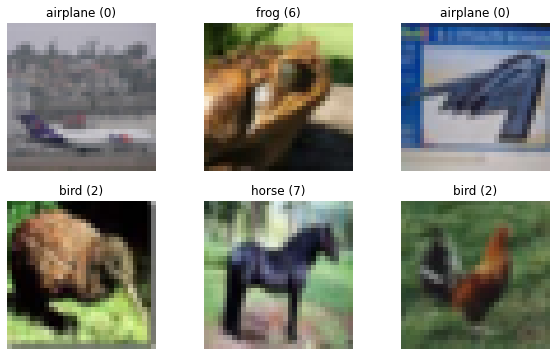

In [6]:
# plot samples
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

samples = ds['train'].select(range(6))
pointer = 0
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['img'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1
plt.show()

In [7]:
from transformers import BeitFeatureExtractor

model_ckpt = 'microsoft/beit-base-patch16-224'
extractor = BeitFeatureExtractor.from_pretrained(model_ckpt)
extractor(samples[0]['img'], return_tensors='pt')

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

In [8]:
def batch_transform(examples):
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['img']], return_tensors='pt')
    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs
transformed_data = ds.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [9]:
transformed_data['train'][10]

{'pixel_values': tensor([[[ 0.8667,  0.8667,  0.8667,  ...,  0.3569,  0.3569,  0.3569],
          [ 0.8667,  0.8667,  0.8667,  ...,  0.3569,  0.3569,  0.3569],
          [ 0.8667,  0.8667,  0.8667,  ...,  0.3569,  0.3569,  0.3569],
          ...,
          [ 0.8196,  0.8196,  0.8196,  ...,  0.8667,  0.8667,  0.8667],
          [ 0.8196,  0.8196,  0.8196,  ...,  0.8667,  0.8667,  0.8667],
          [ 0.8196,  0.8196,  0.8196,  ...,  0.8667,  0.8667,  0.8667]],
 
         [[ 0.6863,  0.6863,  0.6863,  ..., -0.0353, -0.0353, -0.0353],
          [ 0.6863,  0.6863,  0.6863,  ..., -0.0353, -0.0353, -0.0353],
          [ 0.6863,  0.6863,  0.6863,  ..., -0.0353, -0.0353, -0.0353],
          ...,
          [ 0.6471,  0.6471,  0.6471,  ...,  0.7255,  0.7255,  0.7255],
          [ 0.6471,  0.6471,  0.6471,  ...,  0.7255,  0.7255,  0.7255],
          [ 0.6471,  0.6471,  0.6471,  ...,  0.7255,  0.7255,  0.7255]],
 
         [[ 0.6314,  0.6314,  0.6314,  ..., -0.2078, -0.2078, -0.2078],
          [ 

In [10]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }
# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }

<ipython-input-10-45087cd84d02>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


In [11]:
from transformers import BeitForImageClassification

model = BeitForImageClassification.from_pretrained(
    model_ckpt,
    ignore_mismatched_sizes=True,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size
training_args = TrainingArguments(
    output_dir='./content/working/',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=1,
    fp16=True if torch.cuda.is_available() else False,
    logging_steps=logging_steps,
    learning_rate=1e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=transformed_data['train'],
    eval_dataset=transformed_data['test'],
    tokenizer=extractor)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 85769674


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.125300,0.056618,0.986900,0.986883


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16
Saving model checkpoint to ./content/working/checkpoint-3125
Configuration saved in ./content/working/checkpoint-3125/config.json
Model weights saved in ./content/working/checkpoint-3125/pytorch_model.bin
Image processor saved in ./content/working/checkpoint-3125/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./content/working/checkpoint-3125 (score: 0.05661775544285774).


TrainOutput(global_step=3125, training_loss=0.125327744140625, metrics={'train_runtime': 1101.8279, 'train_samples_per_second': 45.379, 'train_steps_per_second': 2.836, 'total_flos': 3.8732212463616e+18, 'train_loss': 0.125327744140625, 'epoch': 1.0})

***** Running Prediction *****
  Num examples = 10000
  Batch size = 16


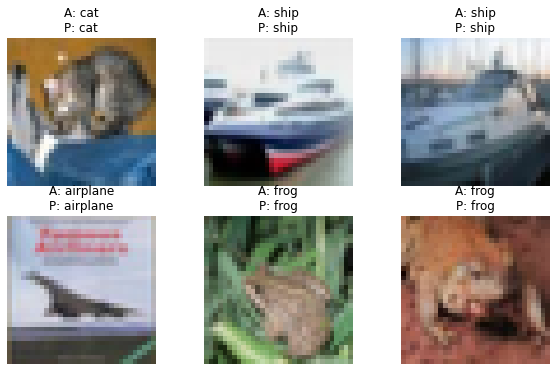

In [13]:
# inference on test data
predictions = trainer.predict(transformed_data['test'])
predictions.metrics
# plot samples
samples = ds['test'].select(range(6))
pointer = 0
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['img'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1
plt.show()

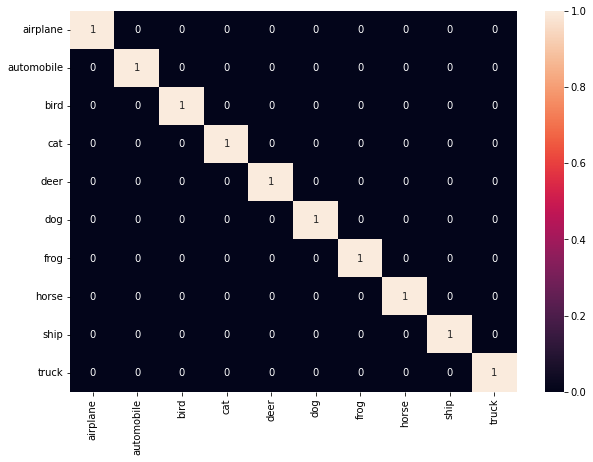

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#Create confusion matrix and normalizes it over predicted (columns)
y_prediction = predictions.label_ids
y_test = [x["label"] for x in transformed_data['test']]
result = confusion_matrix(y_test, y_prediction , normalize='pred')
df_cm = pd.DataFrame(result, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)